In [24]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import requests
from requests import get
import regex as re
from requests import get
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
import timeit
import nltk
from nltk.util import *
from nltk.corpus import stopwords
import re
import seaborn as sns
from collections import defaultdict

In [25]:

url = 'https://photo.stackexchange.com/questions'
time.sleep(5)
# Getting the response from the source URL.
response = get(url)
print(response.text[:500])


<!DOCTYPE html>


    <html class="html__responsive">

    <head>

        <title>Newest Questions - Photography Stack Exchange</title>
        <link rel="shortcut icon" href="https://cdn.sstatic.net/Sites/photo/Img/favicon.ico?v=20ef505cc470">
        <link rel="apple-touch-icon" href="https://cdn.sstatic.net/Sites/photo/Img/apple-touch-icon.png?v=0be01e9424b4">
        <link rel="image_src" href="https://cdn.sstatic.net/Sites/photo/Img/apple-touch-icon.png?v=0be01e9424b4"> 
        


In [26]:

# Parsing respose.txt by creating a BeautifulSoup object and assigning it to htlm_soup.
time.sleep(5)
html_soup = BeautifulSoup(response.text, 'html.parser')

In [29]:
Questions_EachPage = html_soup.find_all('div', class_ = 'question-summary')
print(type(Questions_EachPage))
print(len(Questions_EachPage))

<class 'bs4.element.ResultSet'>
50


In [30]:
from urllib.request import urlopen 
from socket import timeout

url = "https://photo.stackexchange.com/questions?tab=newest&pagesize=50"
try: 
    string = urlopen(url, timeout=5).read()
except ConnectionResetError:
    print("==> ConnectionResetError")
    pass
except timeout: 
    print("==> Timeout")
    pass

In [31]:
pages_list=[]                         # Empty list that will be appended with the page count

pages_list.append("https://photo.stackexchange.com/questions?tab=newest&pagesize=50")

for page in list(range(2, 601)):     # Looping over first 400 webpages

  pages_list.append('https://photo.stackexchange.com/questions?tab=newest&page='+str(page))
  
print(len(pages_list))

600


In [32]:
questions_list=[]                     # Creating an empty list of questions that will be appended with the question counts.

# time.sleep(5)
for x in pages_list:                  # Looping over all the pages in the page list
  page = requests.get(x)
  soup = BeautifulSoup(page.text, 'html.parser')

  question_name = soup.find_all('h3')   # Finding the h3 tag that has details of the question
  for question in question_name:
        if question.find('a'):
            questions_list.append(question.find('a').text)

In [33]:
print(len(questions_list))
print(questions_list[:11])

12532
['current community', 'more stack exchange communities', 'How to shortcut the “release/focus priority” on the FujiFilm X-T4?', 'Blur effect or out of focus?', 'Using Nikon COOLPIX L840 as a webcam [closed]', 'How to improve my jewellery photography?', 'Err 1 with 28-300 L USM lens but is fine when in A mode on my canon 5d Mark iii', 'How to increase quality of photos taken through dslr?', 'Printing negatives: from scans or direct?', 'What do I need to consider when choosing a studio strobe?', 'GIMP. TIFF. Color profile sRGB IEC61966-2.1 and embedded color profile GIMP - built-in sRGB']


In [39]:
# To get the tags from the webpage

def ListToString(string):
  # initialize an empty string 
  string1 = ""
    
  # traverse in the string   
  for element in string:  
      string1 = string1 + element   
     
  return string1


tag=[]

for x in pages_list:
  page = requests.get(x)
  soup = BeautifulSoup(page.text, 'html.parser')

  tags=[]

  for div in soup.find_all('div', {"class": re.compile("^tags")}):      
    tags.append(div.get('class')[1:])



  clean_tags=[]

  for i in tags:
    clean_tags.append(ListToString(i).replace('t-','|'))



  for j in clean_tags:
    tag.append(j[1:])

In [40]:
print(len(tag))
print(tag[:11])

22200
['camera-settings|fujifilm', 'effect|blur', 'nikon|live-view', 'lighting|produc|photography', 'lens|error|canon-5d-mark-iii', 'nikon|image-quality|nikon-d5600', 'printing|35mm|scanning', 'studio-lighting|strobes', 'gimp|tiff', 'lighting|low-light|video|outdoor|canon-70d', 'lightroom|sony-alpha']


In [42]:

# Creating a dataframe for questions and tags

ask_photo_df = pd.DataFrame(list(zip(tag, questions_list)), columns =['Tags', 'Questions']) 
ask_photo_df.head(10)

,Tags,Questions
0,camera-settings|fujifilm,current community
1,effect|blur,more stack exchange communities
2,nikon|live-view,How to shortcut the “release/focus priority” o...
3,lighting|produc|photography,Blur effect or out of focus?
4,lens|error|canon-5d-mark-iii,Using Nikon COOLPIX L840 as a webcam [closed]
5,nikon|image-quality|nikon-d5600,How to improve my jewellery photography?
6,printing|35mm|scanning,Err 1 with 28-300 L USM lens but is fine when ...
7,studio-lighting|strobes,How to increase quality of photos taken throug...
8,gimp|tiff,Printing negatives: from scans or direct?
9,lighting|low-light|video|outdoor|canon-70d,What do I need to consider when choosing a stu...


In [44]:

ask_photo_df['Questions'] = ask_photo_df['Questions'].str.replace('()','')
ask_photo_df['Questions'] = ask_photo_df['Questions'].str.replace(';','')
ask_photo_df['Questions'] = ask_photo_df['Questions'].str.replace(':','')
ask_photo_df['Questions'] = ask_photo_df['Questions'].str.replace('/','')


ask_photo_df['Tags'] = ask_photo_df['Tags'].str.replace('()','')
ask_photo_df['Tags'] = ask_photo_df['Tags'].str.replace(';','')
ask_photo_df['Tags'] = ask_photo_df['Tags'].str.replace(':','')
ask_photo_df['Tags'] = ask_photo_df['Tags'].str.replace('û','.')
ask_photo_df['Tags'] = ask_photo_df['Tags'].str.replace('\t','')

In [49]:
ask_photo_tags = ' '.join(ask_photo_df['Tags'].str.lower())

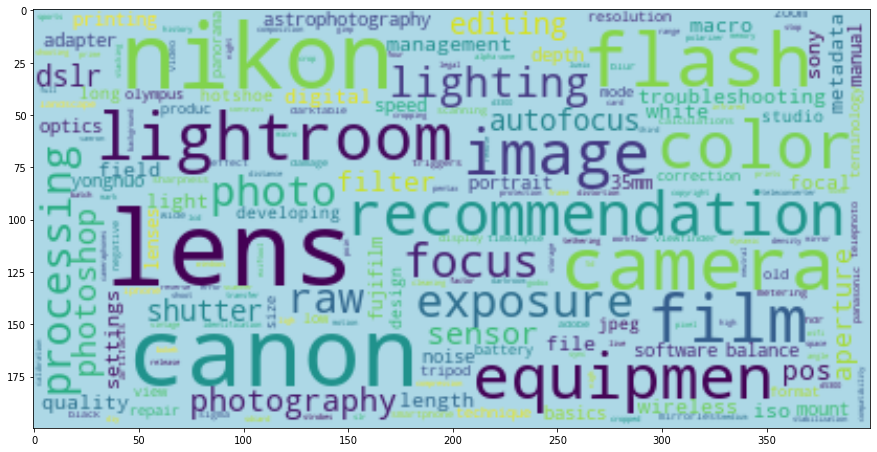

In [53]:
wordcloud = WordCloud(max_font_size=50, collocations=False, background_color='lightblue').generate(ask_photo_tags)
plt.figure(figsize=(15,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [54]:
ask_photo_df["Tags"] = [item.replace("|", " __label__") for item in ask_photo_df["Tags"]]
ask_photo_df['Tags'] ='__label__' + ask_photo_df['Tags'].astype(str)
ask_photo_df.head()

,Tags,Questions
0,__label__camera-settings __label__fujifilm,current community
1,__label__effect __label__blur,more stack exchange communities
2,__label__nikon __label__live-view,How to shortcut the “releasefocus priority” on...
3,__label__lighting __label__produc __label__pho...,Blur effect or out of focus?
4,__label__lens __label__error __label__canon-5d...,Using Nikon COOLPIX L840 as a webcam [closed]
